In [15]:
import numpy as np
import matplotlib.pyplot as plt
import NB_Funcs as hlp

# Loading Data

In [16]:
#each variable in (colony_form_data, ring_form_data, plate_maximums) form
ACK_DF = hlp.pickle_load("../Data/Train_Test/ACK_PreprocessedData")
VIN_DF = hlp.pickle_load("../Data/Train_Test/VIN_PreprocessedData")
ACS_DF = hlp.pickle_load("../Data/Train_Test/ACS_PreprocessedData")
DIFF_DF = hlp.pickle_load("../Data/Train_Test/DIFF_PreprocessedData")

In [17]:
#ACK
K = np.load('../data/RawData/ACK/ACK_K.npy')
N_K = np.load('../data/RawData/ACK/ACK_N_curves.npy')
#VIN
N_N = np.load('../data/RawData/VIN/VIN_N_curves.npy')
#ACS
S_S = np.load('../data/RawData/ACS/ACS_S_curves.npy')
N_S = np.load('../data/RawData/ACS/ACS_N_curves.npy')
#DIFF
N_D = np.load('../data/RawData/DIFF/DIFF_N_curves.npy')
S_D = np.load('../data/RawData/DIFF/DIFF_S_curves.npy')

In [18]:
N_K = N_K[:,:250,:,:]
N_N = N_N[:,:250,:,:]
time1 = np.arange(N_K.shape[1]) * 0.1
time2 = np.arange(N_S.shape[1]) * 0.1

In [19]:
dNdt_K = hlp.cubic_splines(N_K[1],time1); dNovN_K = dNdt_K / N_K[1]
dNdt_N = hlp.cubic_splines(N_N[1],time1); dNovN_N = dNdt_N / N_N[1]
dNdt_S = hlp.cubic_splines(N_S[1],time2); dNovN_S = dNdt_S / N_S[1]
dNdt_D = hlp.cubic_splines(N_D[1],time2); dNovN_D = dNdt_D / N_D[1]

In [20]:
dNovN_K.shape

(250, 32, 48)

In [21]:
meanACK = np.mean(dNovN_K,axis=(1,2))
meanVIN = np.mean(dNovN_N,axis=(1,2))
meanACS = np.mean(dNovN_S,axis=(1,2))
meanDIFF = np.mean(dNovN_D,axis=(1,2))

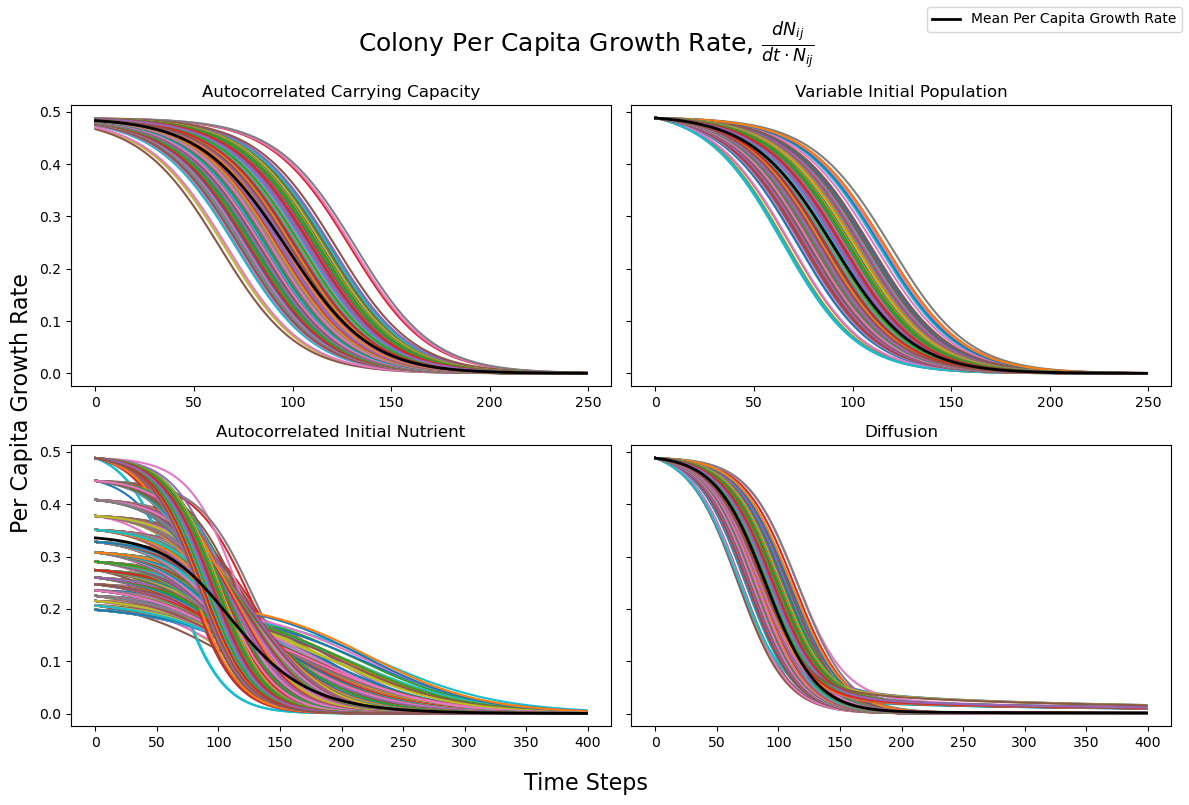

In [22]:
fig, axs = plt.subplots(2,2,figsize=(12,8),sharey=True)

for i in range(N_K.shape[2]):
    for j in range(N_K.shape[3]):
        axs[0][0].plot(dNovN_K[:,i,j]); axs[0][0].set_title("Autocorrelated Carrying Capacity")
        axs[0][1].plot(dNovN_N[:,i,j]); axs[0][1].set_title("Variable Initial Population")
        axs[1][0].plot(dNovN_S[:,i,j]); axs[1][0].set_title("Autocorrelated Initial Nutrient")
        axs[1][1].plot(dNovN_D[:,i,j]); axs[1][1].set_title("Diffusion")
        
# plot mean curves
axs[0][0].plot(meanACK,c='k',lw=2,label='Mean Per Capita Growth Rate')
axs[0][1].plot(meanVIN,c='k',lw=2)
axs[1][0].plot(meanACS,c='k',lw=2)
axs[1][1].plot(meanDIFF,c='k',lw=2)

fig.supylabel("Per Capita Growth Rate",fontsize=16)
fig.supxlabel("Time Steps",fontsize=16)
fig.suptitle(r"Colony Per Capita Growth Rate, $\frac{dN_{ij}}{dt\cdot N_{ij}}$",fontsize=18)
fig.legend()
fig.tight_layout()
plt.show()

In [23]:
NullE_K = hlp.Null_Model_Errors(dNovN_K,meanACK)
NullE_N = hlp.Null_Model_Errors(dNovN_N,meanVIN)
NullE_S = hlp.Null_Model_Errors(dNovN_S,meanACS)
NullE_D = hlp.Null_Model_Errors(dNovN_D,meanDIFF)

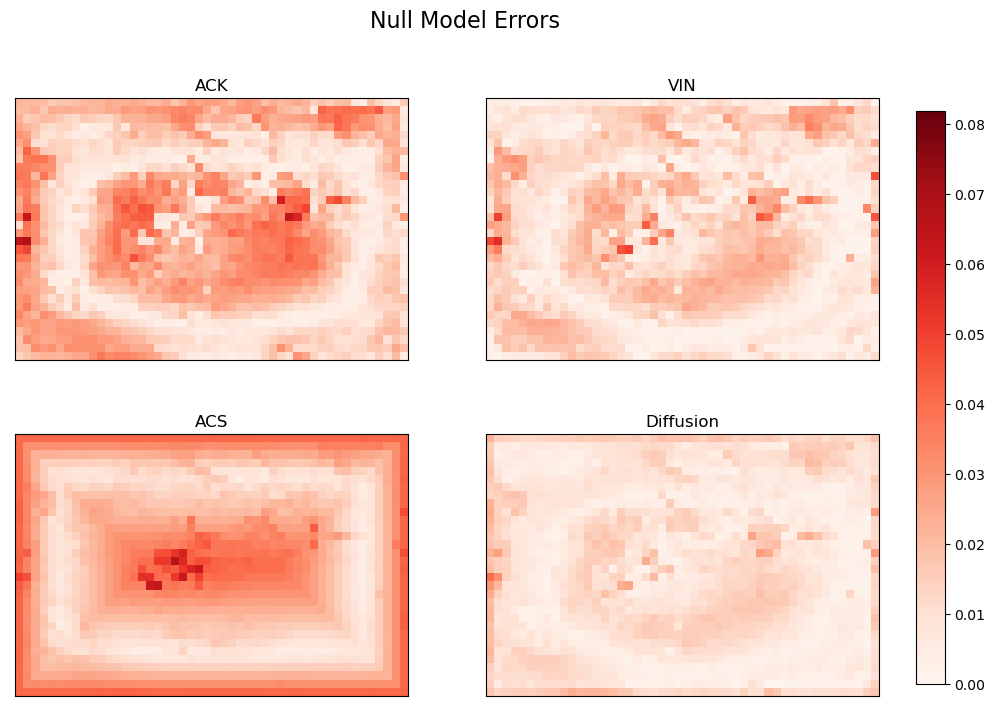

In [30]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
cmax = np.max(NullE_K.mean(axis=2))
K = axs[0,0].imshow(NullE_K.mean(axis=0),cmap='Reds',vmin=0,vmax=cmax); axs[0,0].set_title("ACK")
N = axs[0,1].imshow(NullE_N.mean(axis=0),cmap='Reds',vmin=0,vmax=cmax); axs[0,1].set_title("VIN")
S = axs[1,0].imshow(NullE_S.mean(axis=0),cmap='Reds',vmin=0,vmax=cmax); axs[1,0].set_title("ACS")
D = axs[1,1].imshow(NullE_D.mean(axis=0),cmap='Reds',vmin=0,vmax=cmax); axs[1,1].set_title("Diffusion")

for ax in axs.ravel():
    ax.set_xticks([]);ax.set_yticks([])
    
fig.colorbar(K,ax = axs,fraction=0.046*.67, pad=0.04)
fig.suptitle("Null Model Errors",fontsize=16)
plt.show()

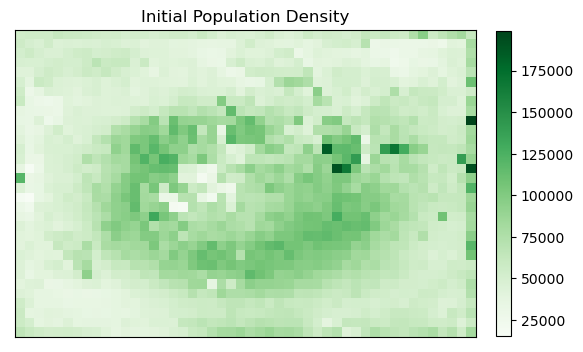

In [31]:
fig, axs = plt.subplots()
N = axs.imshow(N_K[1,0,:,:],cmap='Greens'); axs.set_title("Initial Population Density")

axs.set_xticks([]);axs.set_yticks([])
    
fig.colorbar(N,ax = axs,fraction=0.046*.67, pad=0.04)
plt.show()

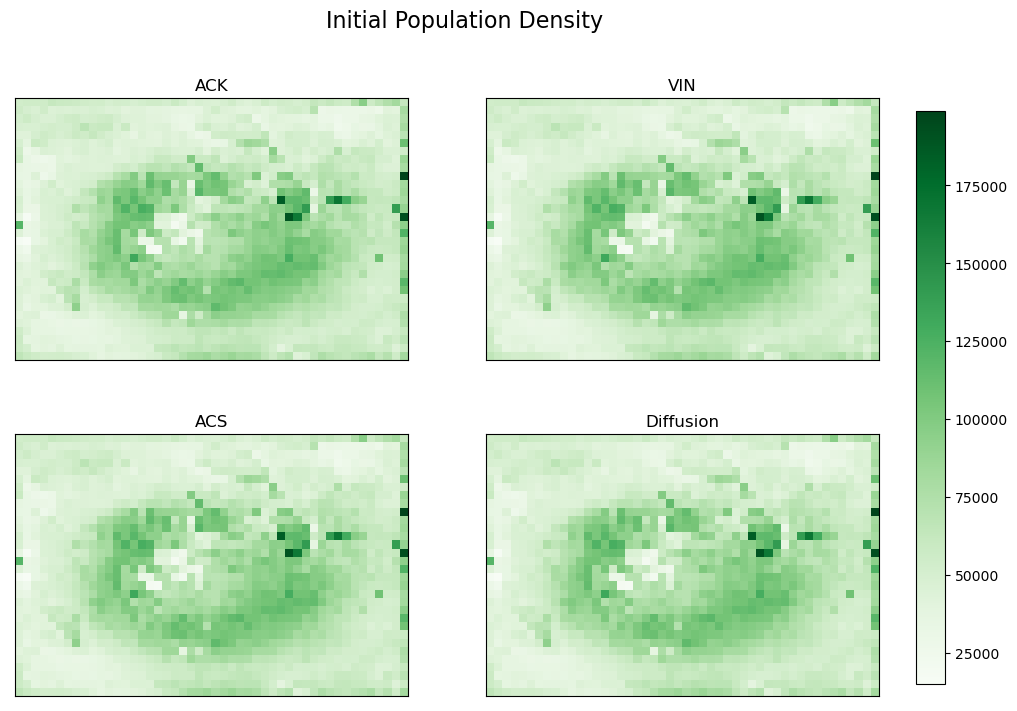

In [26]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
#cmax = np.max(NullE_K.mean(axis=2))
K = axs[0,0].imshow(N_K[1,0,:,:],cmap='Greens'); axs[0,0].set_title("ACK")
N = axs[0,1].imshow(N_N[1,0,:,:],cmap='Greens'); axs[0,1].set_title("VIN")
S = axs[1,0].imshow(N_S[1,0,:,:],cmap='Greens'); axs[1,0].set_title("ACS")
D = axs[1,1].imshow(N_D[1,0,:,:],cmap='Greens'); axs[1,1].set_title("Diffusion")

for ax in axs.ravel():
    ax.set_xticks([]);ax.set_yticks([])
    
fig.colorbar(K,ax = axs,fraction=0.046*.67, pad=0.04)
fig.suptitle("Initial Population Density",fontsize=16)
plt.show()

In [27]:
# TimePoints,Rows,Columns,Features
ACK_D = np.zeros((250,32,48,20))
ACN_D = np.zeros((250,32,48,19))
ACS_D = np.zeros((400,32,48,23))
DIFF_D = np.zeros((400,32,48,23))

# Growth Curves

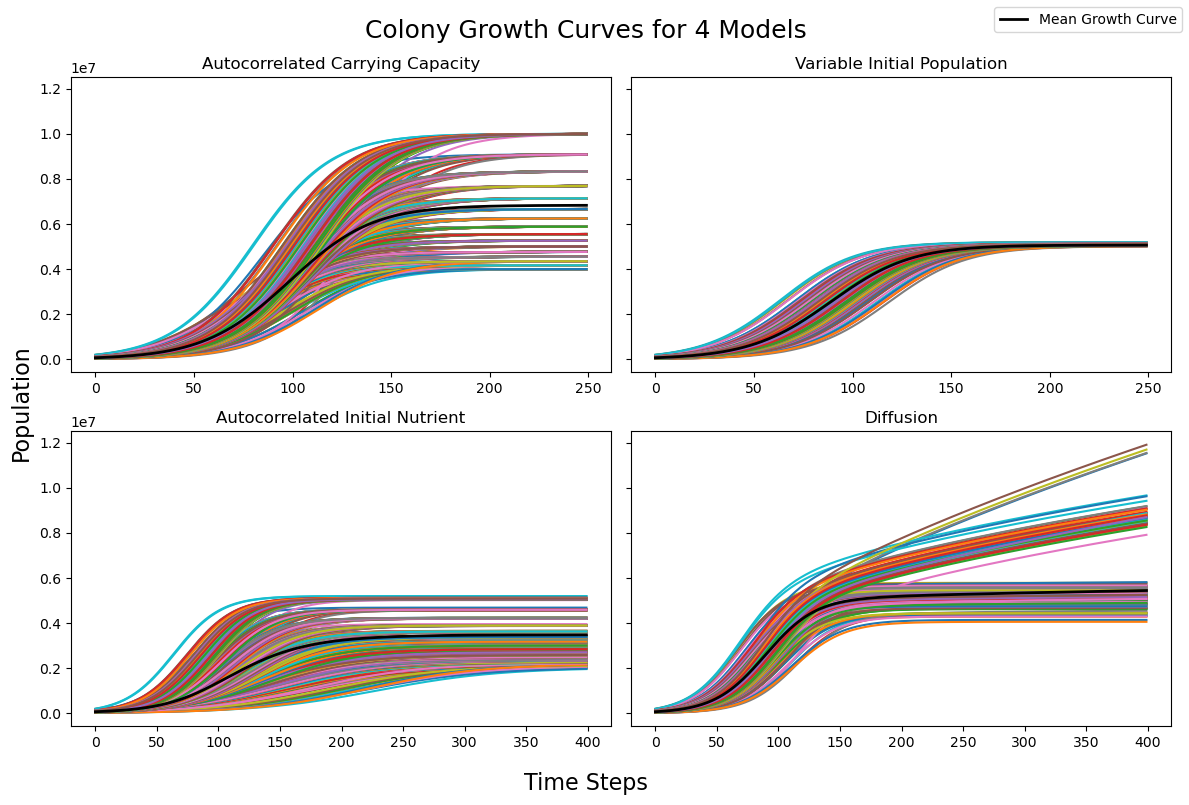

In [28]:
fig, axs = plt.subplots(2,2,figsize=(12,8),sharey=True)

for i in range(N_K.shape[2]):
    for j in range(N_K.shape[3]):
        axs[0][0].plot(N_K[1,:,i,j]); axs[0][0].set_title("Autocorrelated Carrying Capacity")
        axs[0][1].plot(N_N[1,:,i,j]); axs[0][1].set_title("Variable Initial Population")
        axs[1][0].plot(N_S[1,:,i,j]); axs[1][0].set_title("Autocorrelated Initial Nutrient")
        axs[1][1].plot(N_D[1,:,i,j]); axs[1][1].set_title("Diffusion")

# plot mean curves
axs[0][0].plot(np.mean(N_K[1,:,:,:],axis=(1,2)),c='k',lw=2,label='Mean Growth Curve')
axs[0][1].plot(np.mean(N_N[1,:,:,:],axis=(1,2)),c='k',lw=2)
axs[1][0].plot(np.mean(N_S[1,:,:,:],axis=(1,2)),c='k',lw=2)
axs[1][1].plot(np.mean(N_D[1,:,:,:],axis=(1,2)),c='k',lw=2)

fig.supylabel("Population",fontsize=16)
fig.supxlabel("Time Steps",fontsize=16)
fig.suptitle("Colony Growth Curves for 4 Models",fontsize=18)
fig.legend()
fig.tight_layout()
plt.show()